# Tester: Nonlinear Langevin
## Double-welled overdamped Langevin (DWOL)

Here we take for out potential the function $$V(x) = 1/4(x^2-1)^2$$ and so the (overdamped, stochastic) Langenvin equation is $$dX_t = -V'(X_t)dt + \sigma dW_t = -X_t(X_t^2-1) + \sigma dW_t$$
We solve this numerically in various ways to get an approximate solution if to the equation. For instance we will often use Euler-Maruyama which soluction takes the form 
$$Y_{n+1} = Y_{n} + \Delta t\big(-Y_n(Y_n^2-1)\big) + \sigma \sqrt{\Delta t}v_n$$
where $Y_n \approx X_{\Delta t n}$ and $v_n \sim N(0,1)$ for all $n = 0,1,2,\dots$ are i.i.d.

The goal here is to reproduce the statisical and dynamical information (?). Of a realization of $Y = (Y_n;\;n=o,1,2,\dots)$ using a reduced model. We will compare the autocavariances as well as the pdf the $Y_n$. 

So, first we run the full model. To do this I use the function `DataGen_DWOL` found in th file `DataGen.jl` found in the current folder (`Examples\Nonlinear Langevin`).

In [1]:
using PyPlot
using Random

# Get software to generate model
include("../Nonlinear Langevin/DataGen.jl")

# Get model reduction software being tested
include("../../Tools/Model_Reduction_Dev.jl")

# Get tester tools
include("testertools.jl")

┌ Info: Precompiling DSP [717857b8-e6f2-59f4-9121-6e50c889abd2]
└ @ Base loading.jl:1278
┌ Info: Precompiling JLD [4138dd39-2aa7-5051-a626-17a0bb65d9c8]
└ @ Base loading.jl:1278


causal_test (generic function with 1 method)

In [21]:
# Model run Parameters
steps = 10^6 + 1
scheme = "FE"
t_start = 0
t_stop = 10^3
discard = 100000
sig_init = [1.5]
sigma = [.5]
V_prime = x -> -x.*(x.^2 .- 1)
SM1 = false
Obs_noise = false
d = 1
# e = randn(d,steps + discard)

dt = (t_stop - t_start)/(steps - 1)


# Get full model run
Random.seed!(2014)
X = DataGen_DWOL(
    steps;
    scheme, t_start, t_stop, discard, 
    sig_init , sigma, V_prime,
    SM1, Obs_noise, d
    )

1×1000001 Array{Float64,2}:
 1.00609  1.02916  1.03707  1.0349  1.04161  …  0.907385  0.89766  0.905474

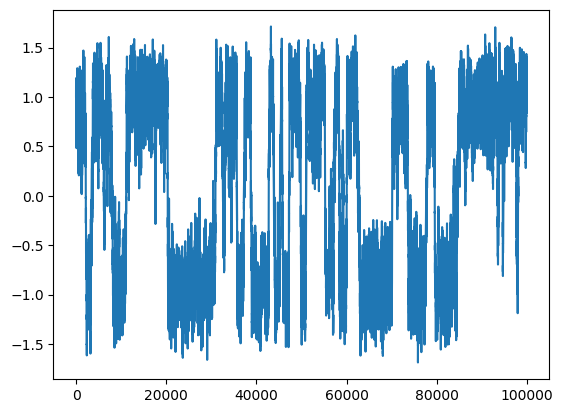

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000496442C8>

In [22]:
plot(X[1,1:10:end])

In [10]:
# Put in Psi functions
Psi(x) = [x; x.^3]

Psi (generic function with 1 method)

In [29]:
dt

0.001

In [11]:
# Model reduction Parameters
M_out = 100
n = 2
p = 500
par = 55
ty = "bin"
rl = true
Preds = true
PI = false
rtol = 1e-6

nfft = 1024

@time h_wf, pred = get_wf(X, Psi;
    M_out, n, p, par, ty, nfft, rl, Preds, PI, rtol);

X_sig = X[:,2:end];

Number of CKMS iterations: 356
errK errR : 9.119083977436453e-11 8.12000230311243e-15
 17.567430 seconds (39.85 M allocations: 3.245 GiB, 8.73% gc time)


1×1000000 Array{Float64,2}:
 1.02916  1.03707  1.0349  1.04161  1.06119  …  0.907385  0.89766  0.905474

In [12]:
pred

2×1000000 Array{Complex{Float64},2}:
 1.00609+0.0im  1.02916+0.0im  …  0.907385+0.0im   0.89766+0.0im
 1.01837+0.0im  1.09006+0.0im     0.747094+0.0im  0.723328+0.0im

## Analyze Wiener Filter

In [13]:
h_wf

1×2×100 Array{Float64,3}:
[:, :, 1] =
 1.0023  -0.00142487

[:, :, 2] =
 -0.00241243  0.000542797

[:, :, 3] =
 0.000676139  8.97813e-6

...

[:, :, 98] =
 1.7031e-5  -4.54525e-6

[:, :, 99] =
 -4.69623e-6  8.85356e-7

[:, :, 100] =
 -4.56289e-6  9.72822e-7

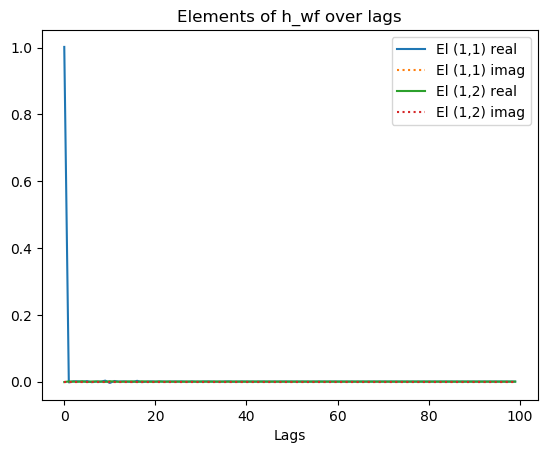

PyObject Text(0.5, 1, 'Elements of h_wf over lags')

In [15]:
plot_WF(h_wf, rl = false)

## Analyze One step prediction error

In [16]:
X_hat = one_step_pred(X_sig, h_wf, pred)

1×1000000 Array{Complex{Float64},2}:
 1.02916+0.0im  1.03707+0.0im  1.0349+0.0im  …  0.907468+0.0im  0.89788+0.0im

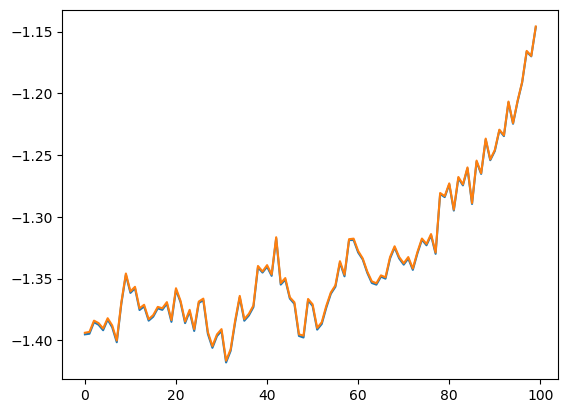

C:\Users\JaredMcBride\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000001771ADC8>
 PyObject <matplotlib.lines.Line2D object at 0x0000000017726988>

In [28]:
wind = (1:100) .+ 24000
plot([X_sig[1,wind] X_hat[1,wind.+1]])

In [18]:
X_err = X_sig - X_hat

1×1000000 Array{Complex{Float64},2}:
 0.0-0.0im  0.0-0.0im  0.0-0.0im  …  -0.00980779-0.0im  0.0075946-0.0im

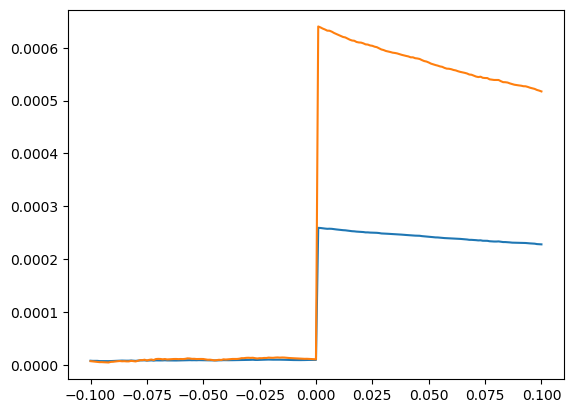

C:\Users\JaredMcBride\.julia\conda\3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000059789748>
 PyObject <matplotlib.lines.Line2D object at 0x0000000059795408>

In [26]:
lags = -100:100
C1 = my_crosscov(pred[1,:],X_err[:],lags);
C2 = my_crosscov(pred[2,:],X_err[:],lags);

plot(dt*lags,[C1 C2])

## Analyze Reduced Model Run

In [17]:
X_rm = redmodrun(X, h_wf, Psi)


reduced model blewup at step 4768
